In [1]:
import torch
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import Dataset
from fastai import DataBunch
from fastai import Learner
import torch.nn.functional as F
torch.backends.cudnn.enabled = False 

C:\Users\Ranet\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### process data

In [2]:
data_path = 'DATA/'

In [3]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open(data_path + 'rus.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[:-1]:
    input_text, target_text = line.split('\t')
    # We use "_bos_" as the "start of sequence" token
    # for the targets, and "_eos_" as "end of sequence" token
    input_text = '_bos_ ' + input_text + ' _eos_'
    target_text = '_bos_ ' + target_text + ' _eos_'
    input_texts.append(input_text)
    target_texts.append(target_text)

num_samples = len(input_texts)
vocab_size = 50000

from itertools import chain
max_len = max(list(chain.from_iterable((len(x.split(' ')), len(y.split(' '))) for x, y in zip(input_texts, target_texts))))

In [4]:
print('Number of samples:', num_samples)
print('Max sequence length for inputs:', max([len(txt.split(' ')) for txt in input_texts]))
print('Max sequence length for outputs:', max([len(txt.split(' ')) for txt in target_texts]))
print('Median sequence length for inputs:', np.median([len(txt.split(' ')) for txt in input_texts]))
print('Median sequence length for outputs:', np.median([len(txt.split(' ')) for txt in target_texts]))

Number of samples: 304513
Max sequence length for inputs: 45
Max sequence length for outputs: 42
Median sequence length for inputs: 8.0
Median sequence length for outputs: 7.0


#### Tokenize

In [5]:
en_tokenizer = Tokenizer(num_words=vocab_size, lower=True, split=' ', oov_token='OOV', filters='')
ru_tokenizer = Tokenizer(num_words=vocab_size, lower=True, split=' ', oov_token='OOV', filters='')
en_tokenizer.fit_on_texts(input_texts)
ru_tokenizer.fit_on_texts(target_texts)

x_t = np.asarray(en_tokenizer.texts_to_sequences(input_texts))
y_t = np.asarray(ru_tokenizer.texts_to_sequences(target_texts))
print(en_tokenizer.word_index['coffee'], en_tokenizer.word_index['OOV'])
print(ru_tokenizer.word_index['кофе'], ru_tokenizer.word_index['OOV'])
print(en_tokenizer.word_index['_bos_'], en_tokenizer.word_index['_bos_'])
print(ru_tokenizer.word_index['_eos_'], ru_tokenizer.word_index['_eos_'])

x_t = pad_sequences(x_t, maxlen=max_len, dtype='int32', padding='post', truncating='post', value=0)
y_t = pad_sequences(y_t, maxlen=max_len, dtype='int32', padding='post', truncating='post', value=0)

761 1
711 1
2 2
3 3


In [6]:
input_texts[0], target_texts[0]

('_bos_ Go. _eos_', '_bos_ Иди. _eos_')

In [7]:
x_t[0], y_t[0], x_t.shape

(array([  2, 205,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]),
 array([    2, 11701,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0]),
 (304513, 45))

### Dataloader

In [8]:
# Split
x_trn, x_val, y_trn, y_val = train_test_split(x_t, y_t, test_size=0.1, random_state=42)

In [9]:
bs=16

class TokDataset(Dataset):
    def __init__(self, x, y):
        self.x = x; self.y = y
        self.len = len(self.x)
        self.x_data = torch.from_numpy(self.x); self.x_data = self.x_data.long()
        self.y_data = torch.from_numpy(self.y); self.y_data = self.y_data.long()
        print('x shape', self.x_data.shape)
        print('y shape', self.y_data.shape)
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len
    
ds = TokDataset(x_trn, y_trn)
ds_val = TokDataset(x_val, y_val)
dl = torch.utils.data.DataLoader(dataset=ds, batch_size=bs, shuffle=True, num_workers=0)
dl_val = torch.utils.data.DataLoader(dataset=ds_val, batch_size=bs, shuffle=True, num_workers=0)

x shape torch.Size([274061, 45])
y shape torch.Size([274061, 45])
x shape torch.Size([30452, 45])
y shape torch.Size([30452, 45])


In [10]:
# Values for testing
test_values = iter(dl)
xs, ys = next(test_values)
xs, ys = xs.t(), ys.t()
print(xs.shape, ys.shape)

torch.Size([45, 16]) torch.Size([45, 16])


In [54]:
class AttentionRNN(nn.Module):
    def __init__(self, inp_sz, out_sz, em_sz, h_sz, n_l, voc_sz):
        super().__init__()
        self.em_sz, self.h_sz, self.n_l, self.inp_sz, self.out_sz, self.voc_sz = em_sz, h_sz, n_l, inp_sz, out_sz, voc_sz
        # Encoder
        self.enc_em = nn.Embedding(self.voc_sz, self.em_sz)
        self.em_drp = nn.Dropout(0.15)
        self.enc_gru = nn.GRU(self.em_sz, self.h_sz, num_layers=self.n_l, dropout=0.2, bidirectional=True)
        # h_sz*2 because of bidir
        self.enc_out = nn.Linear(self.h_sz*2, self.em_sz, bias=False)
        self.enc_drp = nn.Dropout(0.3)
        # Decoder
        self.dec_em = nn.Embedding(self.voc_sz, self.em_sz)
        self.dec_gru = nn.GRU(self.em_sz, self.em_sz, num_layers=self.n_l, dropout=0.2)
        self.dec_out = nn.Linear(self.em_sz, self.voc_sz)
        #self.out.weight.data = self.enc_em.weight.data
        
    def forward(self, inp):
        # seq_len, bs
        sl, bs = inp.shape
        h = self.initHidden(bs)
        x = self.em_drp(self.enc_em(inp))
        enc_gru_out, h = self.enc_gru(x, h)
        # Reshape, to bidir, n_l x bs x -1
        # Permute using indexes to change order of shape (n_l x bs x bidir(2) x n_h)
        # Contiguous to copy the tensor
        # Reshape to flatten the bidir layers, final shape n_l x bs x n_h*2
        h = h.view(2,self.n_l,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.enc_drp(self.enc_out(h))
        
        dec_inp = torch.zeros(bs).long().cuda()
        result = []
        # What is this?
        for i in range(self.out_sz):
            # Get embedding
            emb = self.dec_em(dec_inp).unsqueeze(0)
            # Pass hidden state from (initially) self.enc_out and embedding to dec gru
            outp, h = self.dec_gru(emb, h)
            # Pass decoder output to dense, get probabilities of words in len of vocab_size
            outp = self.dec_out(self.enc_drp(outp[0]))
            result.append(outp)
            # Get ind of biggest value for each batch 
            dec_inp = outp.data.max(1)[1]
            # If all are padding break
            if (dec_inp==0).all():
                break
        # Turn list of tensors into tensor
        return torch.stack(result)
    
    def initHidden(self, bs): 
        # Num_layers, batch size, num hidden
        # n_l*2 because of bidir
        return torch.zeros(self.n_l*2, bs, self.h_sz).cuda()

In [55]:
em_sz = 150
n_h = 64
n_l = 2

inp_sz = max_len
model = AttentionRNN(inp_sz, max_len, em_sz, n_h, n_l, vocab_size).cuda()

In [56]:
test_out = model(xs.cuda())

In [57]:
print(test_out.shape)
# Padding example
print(torch.nn.functional.pad(test_out, (0,0,0,0,0,2)).shape)
# Last seq_len value is padded, so the sum of the vocab_size probs is 0
print(int(torch.sum(torch.nn.functional.pad(test_out, (0,0,0,0,0,2))[-1].view(-1)).data))

torch.Size([45, 16, 50000])
torch.Size([47, 16, 50000])
0


In [58]:
# http://course.fast.ai/lessons/lesson11.html
# http://forums.fast.ai/t/part-2-lesson-11-wiki/14699
# 1 hour in
def seq2seq_loss(input, target):
    # seq_len, bs
    sl,bs = target.size()
    # seq_len, bs, num_channels (vocab size)
    sl_in,bs_in,nc = input.size()
    # If the output sl is smaller than the actual sl, pad it.
    # The shape of input is 'sl x bs x vocab_sz'
    # The reason why have more 0's for padding, is because in PyTorch
    # You have padding on the left, and right, so none on sl or bs or nc left side, but pad on right
    # In this case, pad seq_len on the right by the difference between grount truth sl and input sl
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    # If its too long, just crop it
    input = input[:sl]
    # Cross entropy expects a rank 2 tensor, so flatten the seq_len
    return F.cross_entropy(input.view(-1,nc), target.view(-1))#, ignore_index=1)

### fastai DataBunch and fit

In [59]:
d_bunch = DataBunch(dl, dl_val)
learn = Learner(d_bunch, model, loss_fn=seq2seq_loss)

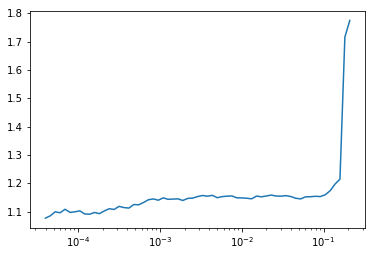

In [65]:
learn.lr_find()
learn.recorder.plot()

In [66]:
lr=1e-4

In [67]:
# TODO use clr 
# fit_one_cycle fits a model following the 1cycle policy.
learn.fit_one_cycle(2, lr)#.fit(1, lr)

KeyboardInterrupt: 

In [41]:
learn.save('initial')

In [37]:
learn.load('initial')

# TODO

In [ ]:

###RUN THROUGH DL2 TRANSLATE NOTEBOOK AND ANSWER THESE QUESTIONS
#########################################
## WHAT IS 

#vecs_enc - 
    # Dict of words, with embedding vectors values
    # https://i.imgur.com/nIELpdY.png
    # https://i.imgur.com/RgBnu4O.png
#itos_enc - 
    # Index to string
    # List of strings, of which the list index is pointing to a word
    # https://i.imgur.com/oq6Kcv1.png
    # https://i.imgur.com/dXSh60V.png
#vecs_dec - Same as vecs_enc, but for dec
#itos_dec - Same as itos_enc but for dec
#########################################
##WHAT DOES create_emb DO
    # Makes an embedding with wiki vectors weights tripled 
## WHAT IS THE sl,bs IN inp.size()
    # bs is batch size
    # sl is seq_len https://i.imgur.com/icfxqv9.png

##WHAT DOES THE FOR LOOP IN FORWARD DO
    # Get encoder input values from embeddings
    # Send enc hidden and embedding to decoder gru
    # Get highest value per patch
    # Append to result

##WHY DO YOU TAKE WEIGHT DATA OF OUTPUT EMBEDDINGS (IS THAT RELATED TO THE RETURN?)


##########################################
###FIGURE OUT THE LOSS FUNCTION
    # Commented
    ## WHY DO YOU PAD THE INPUT LIKE THAT
        # Commented
    ## WHY DO YOU SLICE THE INPUT
        # Commented
##########################################

In [ ]:
# CONVERT IT TO BIDIR
    # Done

In [ ]:
# TEACHER FORCING

In [ ]:
# ATTENTION

In [ ]:
# ALL

In [ ]:
# TRAIN PROPERLY

In [ ]:
# CONVERT MODEL TO PRDOCTION

### Inference

In [68]:
en_itos = dict(map(reversed, en_tokenizer.word_index.items()))
ru_itos = dict(map(reversed, ru_tokenizer.word_index.items()))

In [69]:
x,y = next(iter(dl_val))
probs = learn.model(x.cuda())
preds = probs.max(2)[1].cpu().numpy()
x,y = x.cpu().numpy(), y.cpu().numpy()

for i in range(1,10):
    print(' '.join([en_itos[o] for o in x[i, :] if o != 0]))
    print(' '.join([ru_itos[o] for o in y[i, :] if o != 0]))
    print(' '.join([ru_itos[o] for o in preds[i,:] if o!=0]))
    print()

_bos_ we're all infected. _eos_
_bos_ мы все заражены. _eos_
_bos_ том не не _eos_

_bos_ tom was sitting on the edge of the bed. _eos_
_bos_ том сидел на OOV кровати. _eos_
_bos_ я не _eos_ _eos_

_bos_ i'll stop now. _eos_
_bos_ я остановлюсь сейчас. _eos_
_bos_ я не тут. _eos_

_bos_ why do we have to wait? _eos_
_bos_ почему мы должны ждать? _eos_
_bos_ я не не _eos_ _eos_

_bos_ tom ducked his head. _eos_
_bos_ том пригнул голову. _eos_
_bos_ я не не _eos_

_bos_ i lived there for three years. _eos_
_bos_ я прожил там три года. _eos_
_bos_ я _eos_ не _eos_

_bos_ we are suffering from a severe water shortage this summer. _eos_
_bos_ мы страдаем от серьёзного дефицита воды этим летом. _eos_
_bos_ том не не _eos_

_bos_ i don't even think about it anymore. _eos_
_bos_ я и не думаю об этом больше. _eos_
_bos_ я не не _eos_

_bos_ it's all i need. _eos_
_bos_ это всё, что мне нужно. _eos_
_bos_ я не низкий. _eos_

